
# Diffusion Foundations — **Variational Autoencoder (VAE) from Scratch**
**Pure PyTorch • Baby steps • Richly annotated**

We’ll implement a VAE on MNIST from first principles:
1. Intuition and math (minimally formal)  
2. Encoder → $(\mu, \log\sigma^2)$ reparameterization trick  
3. Decoder → likelihood model (Bernoulli over pixels for MNIST)  
4. ELBO = Reconstruction term + KL term  
5. β-VAE knob, KL warmup  
6. Visuals: reconstructions, prior samples, latent scatter (2D), and interpolations



## Quick intuition
A **VAE** learns a *probabilistic* latent \(z\). Instead of compressing to a single point, the encoder learns a distribution
$(q_phi(z\mid x) = \mathcal{N}(\mu(x), \mathrm{diag}(\sigma^2(x))))$. We then sample \(z\) and ask the decoder $(p_\theta(x\mid z))$ to reconstruct.
We optimize the **ELBO**:
$[
\mathcal{L} = \underbrace{\mathbb{E}_{q_\phi(z\mid x)}[\log p_\theta(x\mid z)]}_{\text{reconstruction}} -
\beta\; \underbrace{\mathrm{KL}\big(q_\phi(z\mid x)\;\Vert\;p(z)\big)}_{\text{regularize towards prior }}
]$


## 0) Setup & Utilities

In [1]:

# %pip install torch torchvision matplotlib --quiet

import os, sys, math, time, random
from dataclasses import dataclass
from typing import Tuple, Dict, Any

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, Dataset

try:
    from torchvision import datasets, transforms, utils as vutils
    HAS_TORCHVISION = True
except Exception as e:
    HAS_TORCHVISION = False
    print("torchvision not available; using synthetic fallback.", e)

import matplotlib.pyplot as plt

def pick_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")

DEVICE = pick_device()
print("Using:", DEVICE)

def set_seed(seed=42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.use_deterministic_algorithms(False)

set_seed(42)

def show_grid(imgs, nrow=8, title=None):
    if HAS_TORCHVISION:
        grid = vutils.make_grid(imgs, nrow=nrow, normalize=False, padding=2)
        plt.figure(figsize=(8,8))
        plt.imshow(grid.permute(1,2,0).cpu().numpy(), interpolation="nearest")
        plt.axis("off")
        if title: plt.title(title)
        plt.show()
    else:
        plt.figure()
        x = imgs[0].permute(1,2,0).cpu().numpy()
        plt.imshow(x, interpolation="nearest")
        plt.axis("off")
        if title: plt.title(title)
        plt.show()


Using: mps


## 1) Data — MNIST with safe fallbacks

Batch: torch.Size([128, 1, 28, 28]) 0.0 1.0


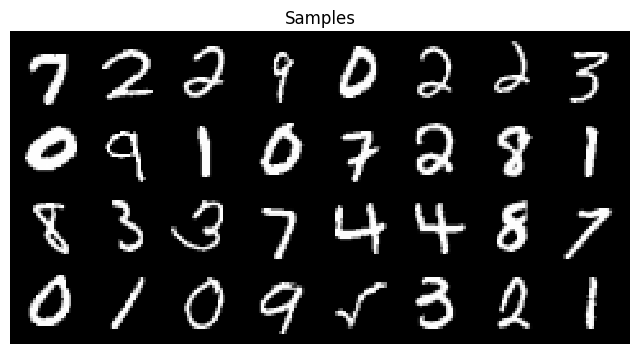

In [2]:

IMG_SIZE = 28
BATCH_SIZE = 128
LIMIT = 10000
NUM_WORKERS = 2 if sys.platform != "win32" else 0

class TinySynthetic(Dataset):
    def __init__(self, n=5000, img_size=28):
        self.n = n; self.img_size = img_size
    def __len__(self): return self.n
    def __getitem__(self, idx):
        img = torch.randn(1, self.img_size, self.img_size).float()
        img = (img - img.min()) / (img.max() - img.min() + 1e-8)
        return img, 0

if HAS_TORCHVISION:
    transform = transforms.ToTensor()
    try:
        train_full = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
        test_set  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
        idx = torch.randperm(len(train_full))[:LIMIT]
        train_set = Subset(train_full, idx.tolist())
    except Exception as e:
        print("MNIST download failed; using FakeData. ", e)
        try:
            train_set = datasets.FakeData(size=LIMIT, image_size=(1, IMG_SIZE, IMG_SIZE), transform=transform)
            test_set  = datasets.FakeData(size=2000, image_size=(1, IMG_SIZE, IMG_SIZE), transform=transform)
        except Exception as e2:
            print("FakeData unavailable; using synthetic fallback. ", e2)
            train_set = TinySynthetic(n=LIMIT, img_size=IMG_SIZE)
            test_set  = TinySynthetic(n=2000, img_size=IMG_SIZE)
else:
    train_set = TinySynthetic(n=LIMIT, img_size=IMG_SIZE)
    test_set  = TinySynthetic(n=2000, img_size=IMG_SIZE)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, drop_last=True)
test_loader  = DataLoader(test_set,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, drop_last=False)

xb, yb = next(iter(train_loader))
print("Batch:", xb.shape, xb.min().item(), xb.max().item())
show_grid(xb[:32], nrow=8, title="Samples")


## 2) VAE — Architecture (Conv encoder/decoder)

In [8]:

@dataclass
class VAEConfig:
    z_dim: int = 2
    lr: float = 1e-3
    epochs: int = 10
    beta: float = 1.0
    kl_warmup: int = 0
    recon_loss: str = "bce"

class ConvVAE(nn.Module):
    def __init__(self, cfg: VAEConfig):
        super().__init__()
        self.cfg = cfg
        self.enc = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=1),  # 28->14
            nn.ReLU(inplace=True),
            nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1), # 14->7
            nn.ReLU(inplace=True),
        )
        self.enc_fc_mu   = nn.Linear(16*7*7, cfg.z_dim)
        self.enc_fc_logv = nn.Linear(16*7*7, cfg.z_dim)
        self.dec_fc = nn.Linear(cfg.z_dim, 16*7*7)
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=1),  # 7->14
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(8, 1, kernel_size=4, stride=2, padding=1),   # 14->28
            nn.Sigmoid(),
        )

    def encode(self, x):
        h = self.enc(x)
        h = h.view(x.size(0), -1)
        mu   = self.enc_fc_mu(h)
        logv = self.enc_fc_logv(h)
        return mu, logv

    def reparameterize(self, mu, logv):
        std = torch.exp(0.5 * logv)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.dec_fc(z)
        h = h.view(z.size(0), 16, 7, 7)
        return self.dec(h)

    def forward(self, x):
        mu, logv = self.encode(x)
        z = self.reparameterize(mu, logv)
        xhat = self.decode(z)
        return xhat, mu, logv, z


## 3) Loss — ELBO (Reconstruction + KL)

In [9]:

def elbo_loss(x, xhat, mu, logv, beta=1.0, recon_loss="bce"):
    if recon_loss == "bce":
        recon = F.binary_cross_entropy(xhat, x, reduction="sum") / x.size(0)
    else:
        recon = F.mse_loss(xhat, x, reduction="sum") / x.size(0)
    kl = 0.5 * torch.sum(torch.exp(logv) + mu.pow(2) - 1.0 - logv) / x.size(0)
    return recon + beta * kl, recon.detach(), kl.detach()


## 4) Training Loop (with β and optional KL warmup)

In [34]:

def train_vae(model, train_loader, test_loader, cfg: VAEConfig, device):
    model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=cfg.lr)
    hist = {"train_total": [], "train_recon": [], "train_kl": [],
            "test_total":  [], "test_recon":  [], "test_kl":   []}

    for epoch in range(cfg.epochs):
        beta_now = (cfg.beta * (epoch + 1) / cfg.kl_warmup) if (cfg.kl_warmup and epoch < cfg.kl_warmup) else cfg.beta
        model.train()
        tr_total = tr_recon = tr_kl = 0.0
        for xb, _ in train_loader:
            xb = xb.to(device)
            xhat, mu, logv, z = model(xb)
            loss, recon, kl = elbo_loss(xb, xhat, mu, logv, beta=beta_now, recon_loss=cfg.recon_loss)
            opt.zero_grad(set_to_none=True)
            loss.backward()
            opt.step()
            tr_total += loss.item(); tr_recon += recon.item(); tr_kl += kl.item()

        model.eval()
        te_total = te_recon = te_kl = 0.0
        with torch.no_grad():
            for xb, _ in test_loader:
                xb = xb.to(device)
                xhat, mu, logv, z = model(xb)
                loss, recon, kl = elbo_loss(xb, xhat, mu, logv, beta=beta_now, recon_loss=cfg.recon_loss)
                te_total += loss.item(); te_recon += recon.item(); te_kl += kl.item()

        ntr, nte = len(train_loader), len(test_loader)
        hist["train_total"].append(tr_total/ntr); hist["train_recon"].append(tr_recon/ntr); hist["train_kl"].append(tr_kl/ntr)
        hist["test_total"].append(te_total/nte);  hist["test_recon"].append(te_recon/nte);  hist["test_kl"].append(te_kl/nte)
        print(f"Epoch {epoch+1:02d}/{cfg.epochs} | beta={beta_now:.3f} | "
              f"train total {hist['train_total'][-1]:.4f} | test total {hist['test_total'][-1]:.4f}")
    return hist

cfg = VAEConfig(z_dim=32, epochs=10, beta=1.0, kl_warmup=0, recon_loss="bce")
vae = ConvVAE(cfg)
hist = train_vae(vae, train_loader, test_loader, cfg, DEVICE)


Epoch 01/10 | beta=1.000 | train total 344.5402 | test total 226.0462
Epoch 02/10 | beta=1.000 | train total 202.7399 | test total 183.3047
Epoch 03/10 | beta=1.000 | train total 170.0861 | test total 157.4666
Epoch 04/10 | beta=1.000 | train total 151.7016 | test total 144.2012
Epoch 05/10 | beta=1.000 | train total 141.5794 | test total 136.0714
Epoch 06/10 | beta=1.000 | train total 134.9715 | test total 130.7644
Epoch 07/10 | beta=1.000 | train total 130.6335 | test total 127.1240
Epoch 08/10 | beta=1.000 | train total 127.4313 | test total 124.5775
Epoch 09/10 | beta=1.000 | train total 124.6213 | test total 122.2209
Epoch 10/10 | beta=1.000 | train total 122.8230 | test total 120.7658


## 5) Plots — Training Curves

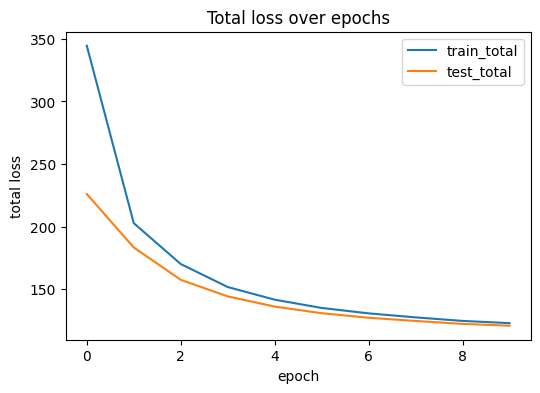

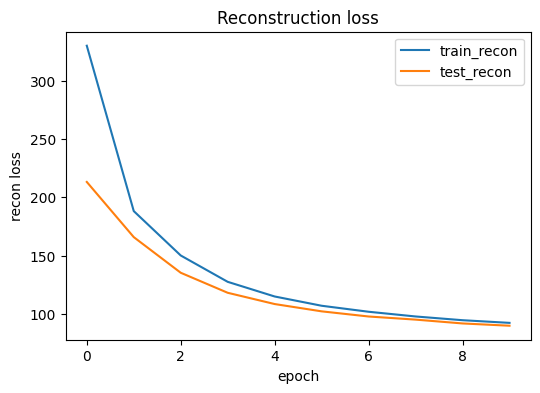

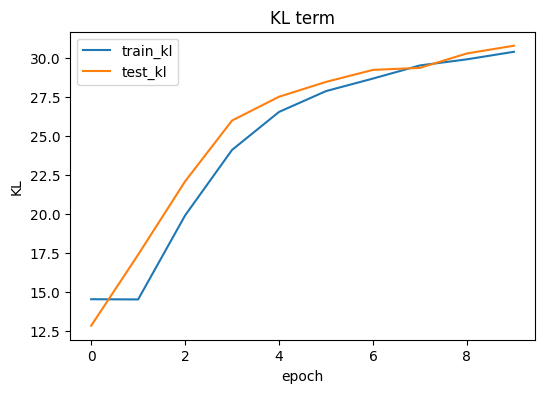

In [35]:

def plot_hist(hist):
    plt.figure(figsize=(6,4))
    plt.plot(hist["train_total"], label="train_total")
    plt.plot(hist["test_total"], label="test_total")
    plt.legend(); plt.xlabel("epoch"); plt.ylabel("total loss"); plt.title("Total loss over epochs"); plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(hist["train_recon"], label="train_recon")
    plt.plot(hist["test_recon"], label="test_recon")
    plt.legend(); plt.xlabel("epoch"); plt.ylabel("recon loss"); plt.title("Reconstruction loss"); plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(hist["train_kl"], label="train_kl")
    plt.plot(hist["test_kl"], label="test_kl")
    plt.legend(); plt.xlabel("epoch"); plt.ylabel("KL"); plt.title("KL term"); plt.show()

plot_hist(hist)


## 6) Visuals — Reconstructions

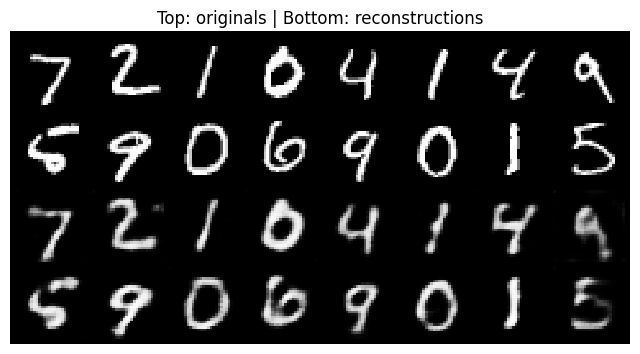

In [36]:

vae.eval()
with torch.no_grad():
    xb, _ = next(iter(test_loader))
    xb = xb.to(DEVICE)[:16]
    xhat, mu, logv, z = vae(xb)
show_grid(torch.cat([xb.cpu(), xhat.cpu()], dim=0), nrow=8, title="Top: originals | Bottom: reconstructions")


## 7) Visuals — Samples from prior p(z)=N(0, I)

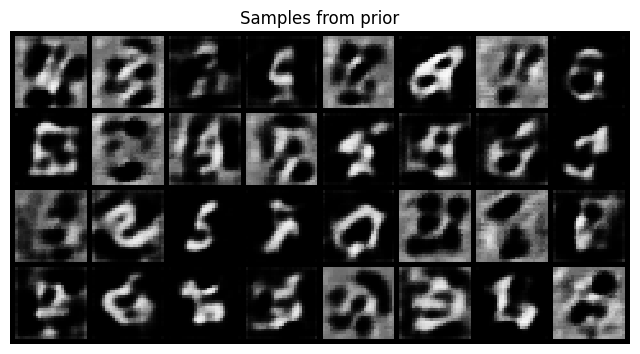

In [37]:

with torch.no_grad():
    z = torch.randn(32, cfg.z_dim, device=DEVICE)
    samples = vae.decode(z).cpu()
show_grid(samples, nrow=8, title="Samples from prior")


## 8) Visuals — Latent 2D Scatter (if z_dim=2)

In [38]:

if cfg.z_dim == 2:
    Z, Y = [], []
    vae.eval()
    with torch.no_grad():
        for i, (xb, yb) in enumerate(test_loader):
            xb = xb.to(DEVICE)
            mu, logv = vae.encode(xb)
            Z.append(mu.cpu()); Y.append(yb)
            if i >= 20: break
    import torch as _t
    Z = _t.cat(Z, 0); Y = _t.cat(Y, 0)
    plt.figure(figsize=(5,5))
    plt.scatter(Z[:,0], Z[:,1], c=Y.numpy(), s=6, alpha=0.7)
    plt.title("Latent means (μ) colored by digit label")
    plt.show()
else:
    print("Set cfg.z_dim=2 for 2D latent scatter.")


Set cfg.z_dim=2 for 2D latent scatter.


## 9) Visuals — Latent Interpolation

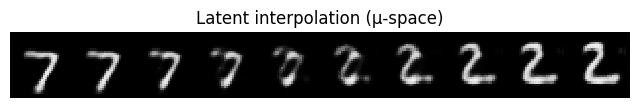

In [39]:

def interpolate(a, b, steps=10):
    alphas = torch.linspace(0, 1, steps, device=a.device).view(-1, 1)
    return (1 - alphas) * a + alphas * b

vae.eval()
with torch.no_grad():
    xb, _ = next(iter(test_loader))
    xb = xb.to(DEVICE)
    x1, x2 = xb[0:1], xb[1:2]
    mu1, _ = vae.encode(x1); mu2, _ = vae.encode(x2)
    Zpath = interpolate(mu1, mu2, steps=10)
    path_imgs = vae.decode(Zpath).cpu()
show_grid(path_imgs, nrow=10, title="Latent interpolation (μ-space)")


## 10) (Optional) KL Warmup Schedule Visual

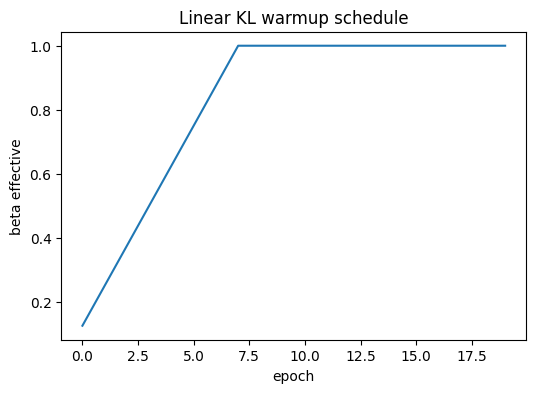

In [40]:

def kl_schedule(total_epochs, beta=1.0, warmup=8):
    vals = []
    for e in range(total_epochs):
        vals.append(beta * float(e+1)/float(warmup) if e < warmup else beta)
    return vals

vals = kl_schedule(20, beta=1.0, warmup=8)
plt.figure(figsize=(6,4))
plt.plot(vals)
plt.xlabel("epoch"); plt.ylabel("beta effective"); plt.title("Linear KL warmup schedule")
plt.show()


## 11) Save & Load

In [41]:

os.makedirs("checkpoints", exist_ok=True)
torch.save(vae.state_dict(), "checkpoints/conv_vae.pt")
print("Saved to checkpoints/conv_vae.pt")

vae2 = ConvVAE(cfg)
vae2.load_state_dict(torch.load("checkpoints/conv_vae.pt", map_location=DEVICE))
vae2.to(DEVICE).eval()
print("Reloaded OK")


Saved to checkpoints/conv_vae.pt
Reloaded OK



## 12) Where we go next (towards Diffusion)
- Swap the decoder likelihood to **Gaussian** for natural images.  
- Scale backbone to **UNet**.  
- From one-shot denoising to **multi-step noise prediction** (DDPM).  
- Use this encoder for latentizing images → diffusion in latent space.
